In [1]:
from ase.atoms import Atoms
from ase.io import read, write
from ase.build import make_supercell
from itertools import product

import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd


In [5]:
from pprint import pprint
from sklearn.preprocessing import normalize, MinMaxScaler

def checkHDistance(struc: Atoms):
    for a in struc:
        for b in struc:
            # print(b.index)
            if (a.index != b.index) and (a.symbol == "H") and (b.symbol == "H"):
                d = struc.get_distance(a.index, b.index)
                if d < 0.8:
                    return False
    else:
        return True

def checkHCage(struc: Atoms):
    contribution_for_cage = 0
    for a in struc:
        for b in struc:
            # print(b.index)
            if (a.symbol != "H") and (b.symbol == "H"):
                d = struc.get_distance(a.index, b.index)
                if (1.8 <= d) and (d <= 2.2) :
                    contribution_for_cage += 1
                    if contribution_for_cage >= 20:
                        return True
                if d < 1.5:
                    return False

    else:
        return False

def checkHdensity(struc: Atoms):
    # 1. 扩包
    # 2. 计算晶格实空间内氢原子的密度：
    #    把晶格打网格，计算每一个网格点在某平均内平均氢原子的个数，即在这一点的H的密度为
    #       Hdensity = V_ball / N_Hatoms
    # 3. 评估这些点所对应的氢的密度有没有特别大的点和特别小的点，使得他们整体差异非常大
    #       Hdensity(x, y, z) = value
    dim = [[2, 0, 0],[0, 2, 0],[0, 0, 2]]
    superstruc = make_supercell(struc, dim)
    positions : np.ndarray = superstruc.positions
    xmin, ymin, zmin = positions.min(axis=0)
    xmax, ymax, zmax = positions.max(axis=0)
    print(xmin, ymin, zmin)
    print(xmax, ymax, zmax)

    x_mesh = np.arange(xmin+1.0, xmax, 1.0, dtype=np.float64)
    y_mesh = np.arange(ymin+1.0, ymax, 1.0, dtype=np.float64)
    z_mesh = np.arange(zmin+1.0, zmax, 1.0, dtype=np.float64)

    points = product(x_mesh, y_mesh, z_mesh)
    total_Hdensity = []
    Hdensity = []
    R = 2.0
    for p in points:
        Nhydrogen = 0
        Hdensity_at_p = 0
        for a in superstruc:
            if a.symbol == "H":
                d = np.linalg.norm(p-a.position)
                if d < R:
                    Nhydrogen += 1

        if not np.isclose(Nhydrogen, 0.0):
            p_Hdensity = (4/3 * np.pi * np.power(R, 3)) / Nhydrogen
            total_Hdensity.append(np.concatenate((p, [p_Hdensity]), axis=0))
            Hdensity.append(p_Hdensity)

    total_Hdensity = normalize(total_Hdensity, norm="l2", axis=1)
    return np.array(total_Hdensity) 



struc = read(f"/Users/macbookpro/my_code/my_script/test/LaH10/LaH10.vasp")
if checkHDistance(struc):
    print("1")
    if checkHCage(struc):
        print("2")
        total_Hdensity = checkHdensity(struc)
        

# print(total_Hdensity)


1
2
0.0 0.0 0.0
9.044809316016215 9.044809316016215 9.044809316016215


In [ ]:
def mean_variance_normalization(data: np.ndarray):
    '''
    计算均值方差归一化
    把所有数据归一到均值为0方差为1的数据中
    既适用于数据没有明显的边界，有可能存在极端数据值的情况。也适用于数据有明显边界的情况
    x_scale =  ( x - x_mean ) / s
        s      是一维数组x的标准差
        x_mean 是一维数组的平均值
        x_scale是一维数组的均值方差归一化值
    '''
    print(data[:4])
    print(np.mean(data[:]))
    print(np.std(data[:]))
    result = (data[:] - np.mean(data[:]))/ np.std(data[:])
    print(f"result= {result[:4]}")
    # np.std 计算标准差 
    #   平均值 = x_mean = np.average((x1 + x2 + ... + xn))
    #   标准差 = [(x1 - x_mean) + (x2 - x_mean) + ... + (xn - x_mean)] / n
    return result

mean_variance_normalization(total_Hdensity[:, 3])

In [6]:
def min_max_normalization(data: np.ndarray):
    '''
    离差标准化
    x = x - min / max - min
    '''
    max = data.max()
    min = data.min()
    result = (data - min) / (max -min)
    return result

print(MinMaxScaler(total_Hdensity[:, 3]))
min_max_normalization(total_Hdensity[:, 3])

MinMaxScaler(feature_range=array([0.96819038, 0.86323766, 0.78400035, 0.74838957, 0.62760216,
       0.67142393, 0.50593843, 0.50767728, 0.592575  , 0.86323766,
       0.71251131, 0.63137833, 0.59027226, 0.48606836, 0.46368282,
       0.41491282, 0.37412074, 0.41164422, 0.78400035, 0.63137833,
       0.53944167, 0.48034196, 0.53265242, 0.44296451, 0.43619546,
       0.36298095, 0.36360007, 0.74838957, 0.59027226...
       0.31483567, 0.34139256, 0.29823864, 0.28824079, 0.27762885,
       0.29727479, 0.36891545, 0.38586644, 0.34026433, 0.3347863 ,
       0.32754328, 0.23768014, 0.27762885, 0.3368945 , 0.25825396,
       0.31300372, 0.32754328, 0.26473263, 0.26069633, 0.2815701 ,
       0.2745923 , 0.29727479, 0.25825396, 0.27829823, 0.30342623,
       0.46479655, 0.34829307, 0.34377352, 0.38614815, 0.37810038,
       0.36891545, 0.31300372, 0.30342623, 0.39497939]))


array([1.        , 0.86847513, 0.76917635, 0.72454956, 0.57318094,
       0.6280976 , 0.42071413, 0.42289322, 0.52928554, 0.86847513,
       0.67958757, 0.57791317, 0.52639978, 0.39581332, 0.36776016,
       0.30664246, 0.25552256, 0.30254632, 0.76917635, 0.57791317,
       0.46269979, 0.3886371 , 0.45419162, 0.34179635, 0.33331349,
       0.24156238, 0.24233825, 0.72454956, 0.52639978, 0.3886371 ,
       0.46828654, 0.36227603, 0.35731271, 0.30880816, 0.26575311,
       0.40245655, 0.57318094, 0.39581332, 0.45419162, 0.36227603,
       0.24306419, 0.27741949, 0.17127388, 0.24452653, 0.31301518,
       0.6280976 , 0.36776016, 0.34179635, 0.35731271, 0.27741949,
       0.2873282 , 0.21256771, 0.18308643, 0.29205501, 0.42071413,
       0.30664246, 0.33331349, 0.30880816, 0.17127388, 0.21256771,
       0.15356192, 0.16194748, 0.27024207, 0.42289322, 0.25552256,
       0.24156238, 0.26575311, 0.24452653, 0.18308643, 0.16194748,
       0.14130931, 0.19715253, 0.52928554, 0.30254632, 0.24233

ValueError: Argument Z must be 2-dimensional.

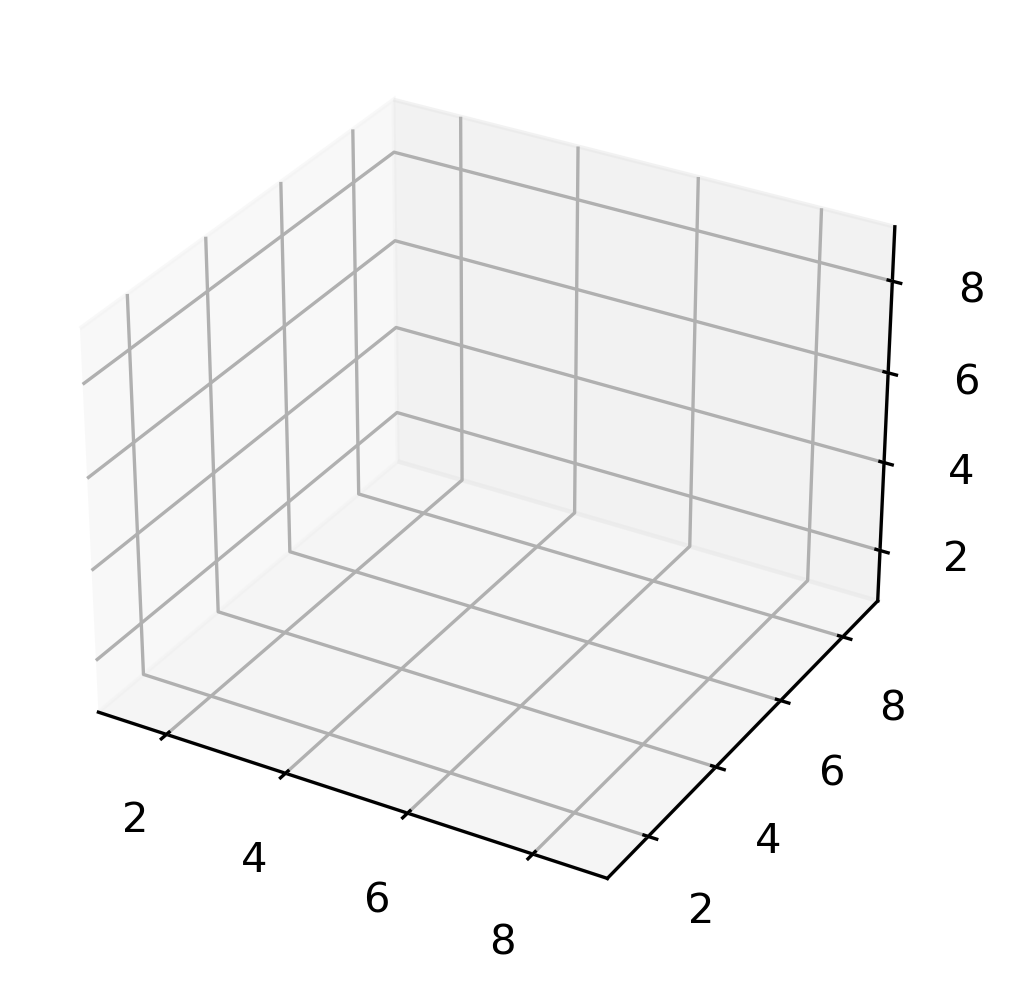

In [61]:
fig = plt.figure(figsize=(4,4), dpi=300)

ax1 = fig.add_subplot(1,1,1, projection='3d') # 前两个1表示：打网格为1*1， 最后一个1表示：将 3d坐标系ax1 放置在第1个格子上

xmin, ymin, zmin, _ = total_Hdensity.min(axis=0)
xmax, ymax, zmax, _ = total_Hdensity.max(axis=0)

ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.set_zlim(zmin, zmax)

# ax1.scatter(total_Hdensity[:, 0], total_Hdensity[:, 1], total_Hdensity[:, 2], total_Hdensity[:, 3])
ax1.stem(total_Hdensity[:, 0], total_Hdensity[:, 1], total_Hdensity[:, 3])
# ax1.stem(total_Hdensity[:, 1], total_Hdensity[:, 2], total_Hdensity[:, 3])
# ax1.stem(total_Hdensity[:, 0], total_Hdensity[:, 2], total_Hdensity[:, 3])

In [15]:
from sklearn.preprocessing import Normalizer
X_test = np.array([
    [ 1,  0,  1,  0],
    [ 1,  1,  1, -1],
    [ 0,  0,  1, -1],
    [-1, -1,  1, -1],
    ])
normalizer = Normalizer().fit(X_test)
normalizer.transform(X_test)

array([[ 0.70710678,  0.        ,  0.70710678,  0.        ],
       [ 0.5       ,  0.5       ,  0.5       , -0.5       ],
       [ 0.        ,  0.        ,  0.70710678, -0.70710678],
       [-0.5       , -0.5       ,  0.5       , -0.5       ]])

In [3]:
import itertools
import numpy as np
from ase.geometry import complete_cell
from ase.geometry.minkowski_reduction import minkowski_reduce
from ase.utils import pbc2pbc
from ase.cell import Cell

def translate_pretty(fractional, pbc):
    """Translates atoms such that fractional positions are minimized."""

    for i in range(3):
        if not pbc[i]:
            continue

        indices = np.argsort(fractional[:, i])
        sp = fractional[indices, i]

        widths = (np.roll(sp, 1) - sp) % 1.0
        fractional[:, i] -= sp[np.argmin(widths)]
        fractional[:, i] %= 1.0
    return fractional


def wrap_positions(positions, cell, pbc=True, center=(0.5, 0.5, 0.5),
                   pretty_translation=False, eps=1e-7):
    """Wrap positions to unit cell.

    Returns positions changed by a multiple of the unit cell vectors to
    fit inside the space spanned by these vectors.  See also the
    :meth:`ase.Atoms.wrap` method.

    Parameters:

    positions: float ndarray of shape (n, 3)
        Positions of the atoms
    cell: float ndarray of shape (3, 3)
        Unit cell vectors.
    pbc: one or 3 bool
        For each axis in the unit cell decides whether the positions
        will be moved along this axis.
    center: three float
        The positons in fractional coordinates that the new positions
        will be nearest possible to.
    pretty_translation: bool
        Translates atoms such that fractional coordinates are minimized.
    eps: float
        Small number to prevent slightly negative coordinates from being
        wrapped.

    Example:

    >>> from ase.geometry import wrap_positions
    >>> wrap_positions([[-0.1, 1.01, -0.5]],
    ...                [[1, 0, 0], [0, 1, 0], [0, 0, 4]],
    ...                pbc=[1, 1, 0])
    array([[ 0.9 ,  0.01, -0.5 ]])
    """

    if not hasattr(center, '__len__'):
        center = (center,) * 3

    pbc = pbc2pbc(pbc)
    shift = np.asarray(center) - 0.5 - eps

    # Don't change coordinates when pbc is False
    shift[np.logical_not(pbc)] = 0.0

    assert np.asarray(cell)[np.asarray(pbc)].any(axis=1).all(), (cell, pbc)

    cell = complete_cell(cell)
    fractional = np.linalg.solve(cell.T,
                                 np.asarray(positions).T).T - shift

    if pretty_translation:
        fractional = translate_pretty(fractional, pbc)
        shift = np.asarray(center) - 0.5
        shift[np.logical_not(pbc)] = 0.0
        fractional += shift
    else:
        for i, periodic in enumerate(pbc):
            if periodic:
                fractional[:, i] %= 1.0
                fractional[:, i] += shift[i]

    return np.dot(fractional, cell)

def naive_find_mic(v, cell):
    """Finds the minimum-image representation of vector(s) v.
    Safe to use for (pbc.all() and (norm(v_mic) < 0.5 * min(cell.lengths()))).
    Can otherwise fail for non-orthorhombic cells.
    Described in:
    W. Smith, "The Minimum Image Convention in Non-Cubic MD Cells", 1989,
    http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.57.1696."""
    f = Cell(cell).scaled_positions(v)
    f -= np.floor(f + 0.5)
    vmin = f @ cell
    vlen = np.linalg.norm(vmin, axis=1)
    return vmin, vlen


def general_find_mic(v, cell, pbc=True):
    """Finds the minimum-image representation of vector(s) v. Using the
    Minkowski reduction the algorithm is relatively slow but safe for any cell.
    """

    cell = complete_cell(cell)
    rcell, _ = minkowski_reduce(cell, pbc=pbc)
    positions = wrap_positions(v, rcell, pbc=pbc, eps=0)

    # In a Minkowski-reduced cell we only need to test nearest neighbors,
    # or "Voronoi-relevant" vectors. These are a subset of combinations of
    # [-1, 0, 1] of the reduced cell vectors.

    # Define ranges [-1, 0, 1] for periodic directions and [0] for aperiodic
    # directions.
    ranges = [np.arange(-1 * p, p + 1) for p in pbc]

    # Get Voronoi-relevant vectors.
    # Pre-pend (0, 0, 0) to resolve issue #772
    hkls = np.array([(0, 0, 0)] + list(itertools.product(*ranges)))
    vrvecs = hkls @ rcell

    # Map positions into neighbouring cells.
    x = positions + vrvecs[:, None]

    # Find minimum images
    lengths = np.linalg.norm(x, axis=2)
    indices = np.argmin(lengths, axis=0)
    vmin = x[indices, np.arange(len(positions)), :]
    vlen = lengths[indices, np.arange(len(positions))]
    return vmin, vlen


def find_mic(v, cell, pbc=True):
    """Finds the minimum-image representation of vector(s) v using either one
    of two find mic algorithms depending on the given cell, v and pbc."""

    cell = Cell(cell)
    pbc = cell.any(1) & pbc2pbc(pbc)
    dim = np.sum(pbc)
    v = np.asarray(v)
    single = v.ndim == 1
    v = np.atleast_2d(v)

    if dim > 0:
        naive_find_mic_is_safe = False
        if dim == 3:
            vmin, vlen = naive_find_mic(v, cell)
            # naive find mic is safe only for the following condition
            if (vlen < 0.5 * min(cell.lengths())).all():
                naive_find_mic_is_safe = True  # hence skip Minkowski reduction

        if not naive_find_mic_is_safe:
            vmin, vlen = general_find_mic(v, cell, pbc=pbc)
    else:
        vmin = v.copy()
        vlen = np.linalg.norm(vmin, axis=1)

    if single:
        return vmin[0], vlen[0]
    else:
        return vmin, vlen



def conditional_find_mic(vectors, cell, pbc):
    """Return list of vector arrays and corresponding list of vector lengths
    for a given list of vector arrays. The minimum image convention is applied
    if cell and pbc are set. Can be used like a simple version of get_distances.
    """
    if (cell is None) != (pbc is None):
        raise ValueError("cell or pbc must be both set or both be None")
    if cell is not None:
        mics = [find_mic(v, cell, pbc) for v in vectors]
        vectors, vector_lengths = zip(*mics)
    else:
        vector_lengths = np.linalg.norm(vectors, axis=2)
    return [np.asarray(v) for v in vectors], vector_lengths

In [22]:
#!/bin/env python
# -*- coding: utf-8 -*-
"""
@author: yyyu200@163.com
"""
import os
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

lw=1.2

F=plt.gcf()
F.clf()
p=plt.subplot(1, 1, 1)

# change by-hand here, read scf input in the future
elem=['H','S']
ielem=np.array([3,1],dtype=np.int32) # number of atoms for each element
orb=[['s'],['s','p']]  # projectors for each element
iorb=np.array([1,2],dtype=np.int32) # number of projectors for each element

num_file=np.dot(ielem,iorb)
nat=np.sum(ielem)
D=[]
N=len(elem)

#scf ATOMIC_POSITIONS should be sorted in the same order as above
count=0
count_at=0
for n in range(N):
    for i in range(ielem[n]):
        for j in range(iorb[n]):
            print(n,i,j,count_at+1,elem[n],j+1,orb[n][j])
            fname='H3S1.pdos_atm#{}({})_wfc#{}({})'.format(count_at+1,elem[n],j+1,orb[n][j])
            path = os.path.join("/home/mayuan/mycode/my_script/test/test_qe/888-200.0", fname)
            D.append(np.loadtxt(path,dtype=np.float32))
            count+=1
        count_at+=1


print(len(D[0]))


e_fermi=17.552
# line1=plt.plot(D[0][:,0]-e_fermi,D[0][:,1]+D[3][:,1],color='g',linewidth=lw,label='Sn s' )
# line2=plt.plot(D[0][:,0]-e_fermi,D[1][:,1]+D[4][:,1],color='r',linewidth=lw,label='Sn p' )
# line3=plt.plot(D[0][:,0]-e_fermi,D[2][:,1]+D[5][:,1],color='b',linewidth=lw,label='Sn d' )

# line4=plt.plot(D[0][:,0]-e_fermi,D[6][:,1]+D[8][:,1]+D[10][:,1]+D[12][:,1],color='cyan',linewidth=lw,label='O s' )
# line5=plt.plot(D[0][:,0]-e_fermi,D[7][:,1]+D[9][:,1]+D[11][:,1]+D[13][:,1],color='grey',linewidth=lw,label='O p' )

line1=plt.plot(D[0][:,0]-e_fermi,D[0][:,1]+D[3][:,1],color='g',linewidth=lw,label='H s' )


plt.xlim([-10,7])
plt.ylim([0,10.5])

plt.ylabel(r'DOS (a.u.)',fontsize=16)
plt.xlabel(r'E (eV) ',fontsize=16)
plt.legend()
plt.savefig('pdos.png',dpi=200)
# plt.show()


0 0 0 1 H 1 s
0 1 0 2 H 1 s
0 2 0 3 H 1 s
1 0 0 4 S 1 s
1 0 1 4 S 2 p
3763
